In [1]:
### libraries
import cv2
from PIL import Image

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Part I: Digit Recognition - NN

In [2]:
### import dataset
num_classes = 10

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_val,  y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(48000, 28, 28) (48000,)
(12000, 28, 28) (12000,)
(10000, 28, 28) (10000,)


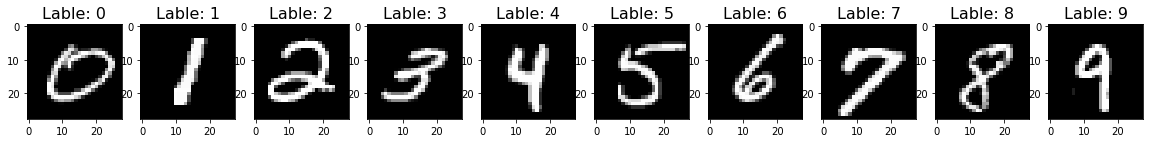

In [3]:
### visualize
f, ax = plt.subplots(1, num_classes, figsize=(20,20))

for i in range(num_classes):
    sample = x_train[y_train == i][0]
    ax[i].imshow(sample, cmap='gray')
    ax[i].set_title('Lable: {}'.format(i), fontsize=16)

In [4]:
num_samples = []
for x in range(num_classes):
    num_samples.append(len(np.where(y_train==x)[0]))
print(num_samples)

[4748, 5420, 4784, 4912, 4666, 4317, 4741, 4966, 4691, 4755]


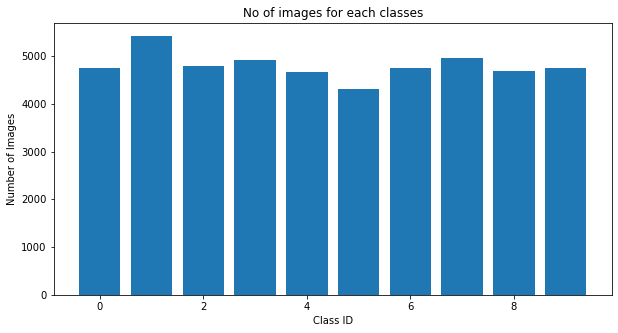

In [5]:
plt.figure(figsize=(10,5))
plt.bar(range(0,num_classes), num_samples)
plt.title('No of images for each classes')
plt.xlabel("Class ID")
plt.ylabel('Number of Images')
plt.show()

In [6]:
### Preprocessing

def normalize(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.bitwise_not(img)
    img = cv2.equalizeHist(img)
    img = img / 255.
#     plt.imshow(img, cmap=plt.cm.binary)
    return img

# Normalize Data
x_train = np.array(list(map(normalize, x_train)))
x_test = np.array(list(map(normalize, x_test)))
x_val = np.array(list(map(normalize, x_val)))

In [7]:
# reshape images
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[2],1)

print('reshape {}'.format(x_train.shape))

reshape (48000, 28, 28, 1)


In [8]:
# Data augmentation
dataGen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
                                                          height_shift_range=0.1,
                                                          zoom_range=0.2,
                                                          shear_range=0.1,
                                                          rotation_range=10)

dataGen.fit(x_train)

In [9]:
# before one-hot enconding
for i in range(10):
    print(y_train[i])
    
# after one-hot enconding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

for i in range(10):
    print(y_train[i])

5
0
1
6
1
3
8
8
1
8
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [10]:
### Model
model = tf.keras.models.Sequential()

model.add((tf.keras.layers.Conv2D(60, (5,5), input_shape=(28,28,1), activation='relu')))
model.add((tf.keras.layers.Conv2D(60, (5,5), activation='relu')))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add((tf.keras.layers.Conv2D(30, (3,3), activation='relu')))
model.add((tf.keras.layers.Conv2D(30, (3,3), activation='relu')))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                    

In [11]:
history = model.fit(dataGen.flow(x_train, y_train), epochs=10, validation_data=(x_val, y_val), shuffle=1)

Epoch 1/10
1500/1500 [==============================] - 11s 6ms/step - loss: 0.5027 - accuracy: 0.8374 - val_loss: 0.0715 - val_accuracy: 0.9791
Epoch 2/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1732 - accuracy: 0.9484 - val_loss: 0.0557 - val_accuracy: 0.9833
Epoch 3/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1312 - accuracy: 0.9611 - val_loss: 0.0514 - val_accuracy: 0.9838
Epoch 4/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1109 - accuracy: 0.9678 - val_loss: 0.0357 - val_accuracy: 0.9894
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0969 - accuracy: 0.9718 - val_loss: 0.0422 - val_accuracy: 0.9879
Epoch 6/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0963 - accuracy: 0.9724 - val_loss: 0.0329 - val_accuracy: 0.9901
Epoch 7/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0855 - accuracy: 0.9758 - val_loss: 0.0369 - val_accuracy

In [12]:
### Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

Test Loss: 0.024441124871373177, Test Accuracy: 0.9922999739646912


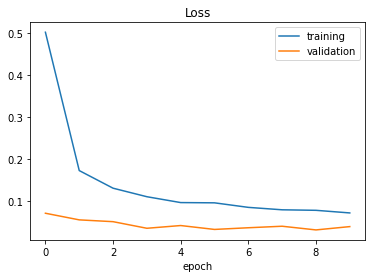

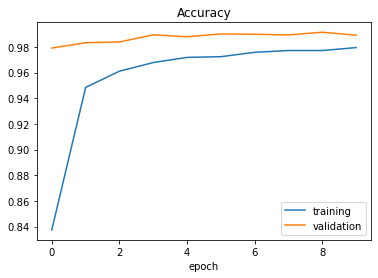

In [13]:
# Graph
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

# Graph
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

In [14]:
### Saving Model
model.save(r'digit-nn.hdf5')

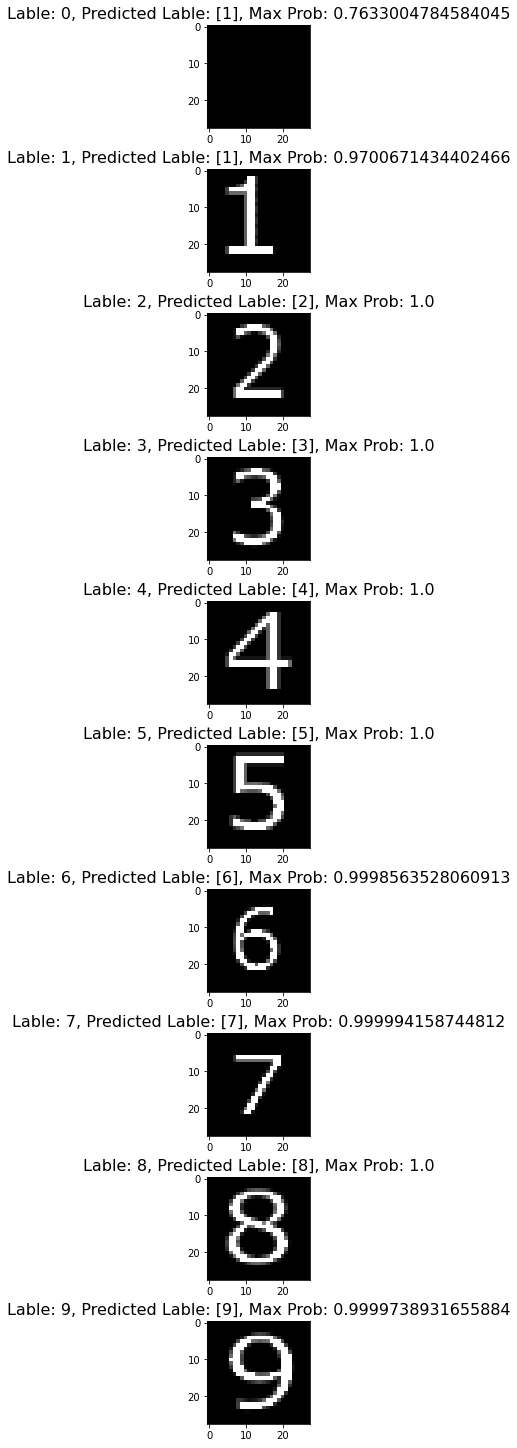

In [15]:
### Test
fig, ax = plt.subplots(num_classes, 1, figsize=(20,20), constrained_layout = True)
    
    
for i in range(10):
    testImage = cv2.imread(f'digit/{i}.PNG')
    testImage = np.asarray(testImage)
    testImage = cv2.resize(testImage, (28,28))

    testImage = normalize(testImage)
    testImage = testImage.reshape(1,28,28,1)
    
    # predict
    prediction = model.predict(testImage) 
    predictProb = np.amax(prediction)
    classes_x=np.argmax(prediction,axis=1)
    
    # plot
    testImage = testImage.reshape(28,28)
    ax[i].imshow(testImage, cmap='gray')
    ax[i].set_title('Lable: {}, Predicted Lable: {}, Max Prob: {}'.format(i,classes_x,predictProb), fontsize=16)

plt.show()

### Part II: Computer Vision 

In [46]:
class SudokuSolver:
    def __init__(self, sudoku, model="", final_solution = []):
        self.__model = tf.keras.models.load_model('digit-nn.hdf5') if model == "" else model
        self.__sudoku = sudoku
        self.__canvas_1 = sudoku.copy()
        self.__canvas_2 = sudoku.copy()
        self.__width = 450
        self.__height = 450
        self.__boxes = []
        self.__cropped_boxes = []
        self.__board = []
        self.__detected_number = np.zeros((self.__height, self.__width, 3), np.uint8)
        self.__final_solution_board = np.zeros((self.__height, self.__width, 3), np.uint8)
        self.__final_solution = final_solution
        
    
        
    # To display the solution on the Image
    def __displayNumbers(self,img, numbers, color = (0,255,0)):
        img = img
        numbers = numbers
        secW = int(img.shape[1]/9)
        secH = int(img.shape[0]/9)
        for x in range (0,9):
            for y in range (0,9):
                if numbers[(y*9)+x] != 0 :
                     cv2.putText(img, str(numbers[(y*9)+x]),
                                   (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                2, color, 2, cv2.LINE_AA)
        return img
    
    ### draw board
    def display_board(self, index=0):
        fig, ax = plt.subplots(2,4, figsize=(10,10))
        
        ax[0,0].imshow(self.__sudoku) 
        ax[0,0].set_title('Original Image') 
        
        ax[0,1].imshow(self.__canvas_1) 
        ax[0,1].set_title('Contour')
        
        ax[0,2].imshow(self.__canvas_2) 
        ax[0,2].set_title('Sudoku box border')
        
        ax[0,3].imshow(self.__detected_number)
        ax[0,3].set_title(f'Detected Numbers')
        
        ax[1,0].imshow(self.__boxes[index]) 
        ax[1,0].set_title(f'BEFORE\nREMOVING BORDER\nSplit box at index: {index}')
        
        ax[1,1].imshow(self.__cropped_boxes[index]) 
        ax[1,1].set_title(f'AFTER\nREMOVING BORDER\nSplit box at index: {index} ')
        
        ax[1,2].imshow(self.__cropped_boxes[index]) 
        ax[1,2].set_title(f'Predicted Digit: {self.__board[index]}')
        
        ax[1,3].imshow(self.__final_solution_board) 
        ax[1,3].set_title(f'With Solution')
        
        fig.tight_layout()
        plt.show()

    ### preprocessing
    def __preprocess(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
        blur = cv2.GaussianBlur(gray, (3,3), 6)
        thres = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
        return thres
    
    ### detecting all the contour
    def __get_contour(self):
        threshold = self.__preprocess(self.__sudoku)
        contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(self.__canvas_1, contours, -1, (0,255,0), 3)
        return contours
    
    ### get the sudoku board's contour outline
    def __get_board_outline(self, contours):
        biggest = np.array([])
        max_area = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 50:
                peri = cv2.arcLength(contour, True)
                approx = cv2.approxPolyDP(contour, 0.02*peri, True)
                if area > max_area and len(approx) == 4:
                    biggest = approx
                    max_area = area
        return biggest, max_area
    
    ### reframe the board
    def __reframe(self, points):
        points = points.reshape((4,2))
        points_new = np.zeros((4,1,2), dtype=np.int32)
        add = points.sum(1)
        points_new[0] = points[np.argmin(add)]
        points_new[3] = points[np.argmax(add)]
        diff = np.diff(points, axis=1)
        points_new[1] = points[np.argmin(diff)]
        points_new[2] = points[np.argmax(diff)]
        return points_new
    
    ### crop the sudoku board
    def __get_crop_board(self):
        contours = self.__get_contour()
        biggest, maxArea = self.__get_board_outline(contours)
        if biggest.size != 0:
            biggest = self.__reframe(biggest)
            cv2.drawContours(self.__canvas_2, biggest, -1, (0,255,0), 15)
            pts1 = np.float32(biggest)
            pts2 = np.float32([[0,0], [self.__width,0], [0,self.__height], [self.__width,self.__height]])
            matrix = cv2.getPerspectiveTransform(pts1, pts2)
            imageWrape = cv2.warpPerspective(self.__sudoku, matrix, (self.__width,self.__height))
            imageWrape = cv2.cvtColor(imageWrape, cv2.COLOR_BGR2GRAY)
        return imageWrape
    
    ### split the sudoku board to small boxes
    def __split_board(self, image):
        rows = np.vsplit(image, 9)
        for row in rows:
            cols = np.hsplit(row, 9)
            for col in cols:
                self.__boxes.append(col)
    
    ### crop the cell
    def __crop_cell(self):
        for cell in self.__boxes:
            img = np.array(cell)
            img = img[5:46, 6:46]
            img = Image.fromarray(img)
            self.__cropped_boxes.append(img)
            
    ### normalizing cell for prediction
    def __normalize(self, img):
        img = cv2.bitwise_not(img)
        img = img / 255.
        return img
    
    ### getting the prediction on the split cell
    def __get_prediction(self):
        result = []
        
        # get the wrape image
        image_wrape = self.__get_crop_board()
        self.__split_board(image_wrape)
        self.__crop_cell()
        
        for cropped_box in self.__cropped_boxes:
            #convert plt.Image to np.array
            cropped_box = np.asarray(cropped_box)
            #resize
            cropped_box = cv2.resize(cropped_box, (28,28))
            #normalize
            cropped_box = self.__normalize(cropped_box)
            #reshape
            cropped_box = cropped_box.reshape(1,28,28,1)
            # predict
            prediction = self.__model.predict(cropped_box) 
            prediction_prob = np.amax(prediction)
            if prediction_prob >= .90:
                self.__board.append(np.argmax(prediction))
            else:
                self.__board.append(0)
    
    ### get sudoku board in 2D array format
    def get_board(self):
        self.__get_prediction()
        self.__detected_number = self.__displayNumbers(img=self.__detected_number, numbers=self.__board)
        return np.array_split(self.__board,9)
    
    def get_solution(self, solution):
        self.__final_solution = solution
        self.__final_solution_board = self.__displayNumbers(img=self.__final_solution_board, numbers=self.__final_solution)

In [47]:
# read the sudoku board image
sudoku = cv2.imread('./1.png')

sudokuSolver = SudokuSolver(sudoku=sudoku)
game = sudokuSolver.get_board()

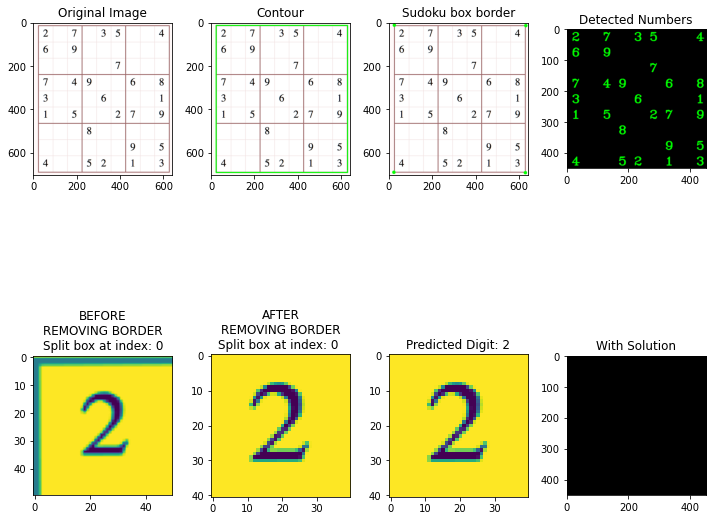

In [48]:
sudokuSolver.display_board(index=0)

### Part III: Sudoku Solver - NN

In [17]:
### Load dataset https://www.kaggle.com/datasets/bryanpark/sudoku
def load_data(file_path):
    sudokus = pd.read_csv(file_path, header=0).values

    quizzes, solutions = sudokus.T # raw features and raw labels

    features, labels = [], []

    for quizz in quizzes:
        x_shaped = np.array([int (j) for j in quizz]).reshape((9,9,1))
        features.append(x_shaped)

    for solution in solutions:
        y_shaped = np.array([int (j) for j in solution]).reshape((81,1)) - 1
        labels.append(y_shaped)
        
    # normalized
    features = np.array(features)
    features = features/9
    features -= .5

    labels = np.array(labels)
    
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    return x_train, x_test, y_train, y_test

In [18]:
file = './dataset/sudoku.csv'
x_train, x_test, y_train, y_test = load_data(file_path=file)

In [19]:
### train model
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(81*9))
model.add(tf.keras.layers.Reshape((-1, 9)))
model.add(tf.keras.layers.Activation('softmax'))

adam = tf.keras.optimizers.Adam(learning_rate=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 9, 9, 64)          640       
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 flatten_1 (Flatten)         (None, 10368)            

In [21]:
history = model.fit(x_train, y_train, validation_split=0.2, epochs=2)

Epoch 1/2
20000/20000 [==============================] - 84s 4ms/step - loss: 0.4641 - accuracy: 0.7899 - val_loss: 0.3720 - val_accuracy: 0.8198
Epoch 2/2
20000/20000 [==============================] - 81s 4ms/step - loss: 0.3632 - accuracy: 0.8253 - val_loss: 0.3609 - val_accuracy: 0.8266


In [22]:
### Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: {}, Test Accuracy: {}'.format(test_loss, test_acc))

Test Loss: 0.3610790967941284, Test Accuracy: 0.8264927864074707


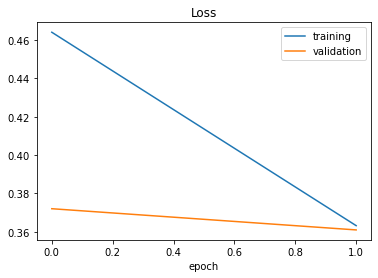

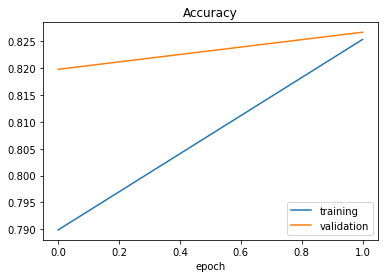

In [23]:
# # Graph
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')

# Graph
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

plt.show()

In [56]:
### Saving model
model.save(r'sudoku-solver-nn.hdf5')

In [24]:
import copy
### testing
def norm(a):
    return (a/9)-.5

def denorm(a):
    return (a+.5)*9

def inference_sudoku(sample):
    '''
        This function solve the sudoku by filling blank positions one by one.
    '''
    feat = copy.copy(sample)
    
    while(1):
        out = model.predict(feat.reshape((1,9,9,1)))  
        out = out.squeeze()

        pred = np.argmax(out, axis=1).reshape((9,9))+1 
        prob = np.around(np.max(out, axis=1).reshape((9,9)), 2) 
        
        feat = denorm(feat).reshape((9,9))
        mask = (feat==0)
     
        if(mask.sum()==0):
            break
            
        prob_new = prob*mask
    
        ind = np.argmax(prob_new)
        x, y = (ind//9), (ind%9)

        val = pred[x][y]
        feat[x][y] = val
        feat = norm(feat)
    
    return pred

def test_accuracy(feats, labels):
    correct = 0   
    for i,feat in enumerate(feats):
        pred = inference_sudoku(feat)
        true = labels[i].reshape((9,9))+1
        if(abs(true - pred).sum()==0):
            correct += 1
    print(correct/feats.shape[0])

In [25]:
test_accuracy(x_test[:100], y_test[:100])

1.0


In [26]:
def solve_sudoku(game):
    game = np.asarray(game)
    game = game.reshape((9,9,1))
    game = norm(game)
    game = inference_sudoku(game)
    return game

In [50]:
game1 = solve_sudoku(game)

print('solved puzzle:\n')
print(game1)

solved puzzle:

[[2 1 7 6 3 5 8 9 4]
 [6 4 9 2 1 8 3 5 7]
 [5 8 3 4 9 7 2 1 6]
 [7 2 4 9 5 1 6 3 8]
 [3 9 8 7 6 4 5 2 1]
 [1 6 5 3 8 2 7 4 9]
 [9 5 1 8 7 3 4 6 2]
 [8 3 2 1 4 6 9 7 5]
 [4 7 6 5 2 9 1 8 3]]


In [54]:
sudokuSolver.get_solution(game1.flatten().tolist())

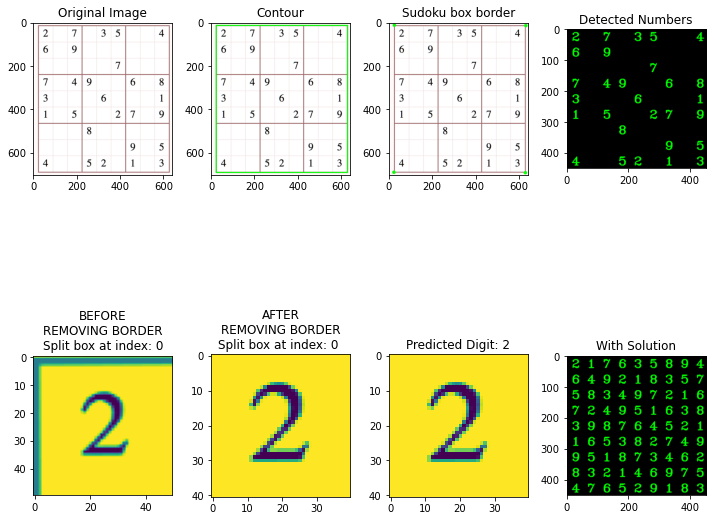

In [55]:
sudokuSolver.display_board()